In [1]:
# prompt: 구글 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: unzip "/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/archive (3).zip"

# !unzip "/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/archive (3).zip" -d "/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/"


Archive:  /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/archive (3).zip
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test.csv  
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/e4dcca36ceb4.png  
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/e4e343eaae2a.png  
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/e4f12411fd85.png  
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/e50b0174690d.png  
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/e5197d77ec68.png  
  inflating: /content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/e529c5757d64.png  
  inflating: /content/

In [ ]:
# Importing Packages
import numpy as np
import cv2
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [ ]:
file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
df = pd.read_csv(file_path)

In [ ]:
folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images'
image_pattern = '*.png'
image_files = glob.glob(os.path.join(folder_path, image_pattern))

(2136, 3216, 3)


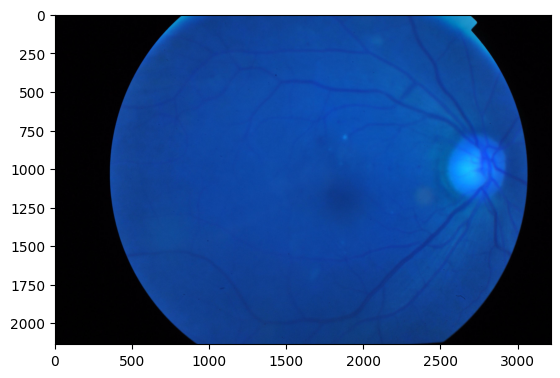

In [ ]:
img = cv2.imread('/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images/1ae8c165fd53.png')
print(img.shape)
plt.imshow(img)

In [ ]:
data = []
labels = []

image_size=(128,128)
for index, row in df.iterrows():
    image_path = f"/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(row['diagnosis'])

In [ ]:
X_train = np.array(data)
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
y_train = np.array(labels, dtype=np.int32)

print(X_train.shape)
print(y_train.shape)

(2930, 128, 128, 3)
(2930,)


In [ ]:
print(y_train)

[2 1 4 ... 0 0 0]


In [ ]:
## Pre trained model load
from tensorflow.keras.applications import VGG16,MobileNetV2,InceptionV3,DenseNet121,ResNet50,ResNet101

In [ ]:
# Top layer는 DR Problem에 맞도록 조정할 예정이고, ImageNet으로 Pretrained weight를 사용
# Transfer learning 방식
base_model = ResNet50(input_shape=(128,128,3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.layers import Flatten,Dense

new_model=base_model.get_layer('conv5_block3_out').output #last layer of your pretrained model
output1=Flatten()(new_model)
output=Dense(units=512,activation='relu')(output1)
output=Dense(units=5, activation='softmax')(output)

In [ ]:
from tensorflow.keras.models import Model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,368,005 (153.99 MB)

 Trainable params: 16,780,293 (64.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/valid.csv')

val_data = []
val_labels = []

image_size = (128,128)

for index, row in val_df.iterrows():
    image_path = f"/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/val_images/val_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    val_data.append(image)
    val_labels.append(row['diagnosis'])

In [ ]:
X_val = np.array(val_data)
X_val = (X_val - np.min(X_val)) / (np.max(X_val) - np.min(X_val)).astype(np.float32)
y_val = np.array(val_labels, dtype=np.int32)

print(X_val.shape)
print(y_val.shape)

(366, 128, 128, 3)
(366,)


In [ ]:
print(y_val)

[2 4 1 0 0 4 0 2 2 1 0 2 0 3 1 0 2 0 0 2 2 0 1 2 0 2 0 0 0 0 0 0 4 2 4 2 0
 0 4 0 4 2 2 4 2 1 2 4 0 3 1 2 2 2 2 0 3 0 2 1 0 2 0 0 0 0 2 2 0 0 0 1 1 0
 3 0 2 0 2 0 1 3 1 0 2 0 0 3 4 2 2 0 0 0 0 1 0 3 1 0 2 2 0 0 0 4 4 0 0 1 2
 4 0 0 2 0 0 0 0 0 3 0 2 2 0 0 4 0 0 1 0 2 0 2 2 2 1 0 0 1 0 0 0 2 0 2 1 4
 0 2 0 2 0 0 0 0 0 0 4 2 0 0 2 2 2 3 2 0 3 0 0 0 0 4 0 2 0 1 0 0 0 2 0 0 0
 0 2 0 1 3 1 0 4 0 0 2 4 0 1 0 3 0 2 2 0 1 0 3 3 1 2 0 0 2 2 0 2 0 0 2 1 0
 0 1 0 0 0 2 2 0 1 0 4 1 1 2 4 2 2 2 0 2 0 2 0 2 2 0 0 0 0 1 1 2 0 2 0 2 1
 0 0 0 2 0 2 2 2 2 0 2 2 2 0 3 2 0 0 0 0 2 2 0 2 2 0 3 0 1 2 0 4 3 0 0 0 0
 3 2 0 4 0 0 0 4 3 4 2 1 0 2 0 0 0 0 0 2 1 0 2 2 2 0 0 0 0 4 0 2 0 0 2 1 0
 0 0 0 2 2 0 2 2 3 0 3 2 1 0 2 2 1 0 0 1 4 1 0 0 2 0 2 4 4 3 0 2 0]


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50, batch_size=16)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.5661 - loss: 1.4386 - val_accuracy: 0.6421 - val_loss: 0.9461
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6903 - loss: 0.8956 - val_accuracy: 0.6393 - val_loss: 0.8905
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6547 - loss: 0.9471 - val_accuracy: 0.6749 - val_loss: 0.8774
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6825 - loss: 0.8693 - val_accuracy: 0.6858 - val_loss: 0.8378
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6839 - loss: 0.8775 - val_accuracy: 0.6667 - val_loss: 0.8392
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6987 - loss: 0.8483 - val_accuracy: 0.7295 - val_loss: 0.8109
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7031 - loss: 0.8140 - val_accuracy: 0.7022 - val_loss: 0.8245
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6705 - loss: 0.8708 - val_acc

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test.csv')

test_data = []
test_labels = []

image_size = (128,128)

for index, row in test_df.iterrows():
    image_path = f"/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    test_data.append(image)
    test_labels.append(row['diagnosis'])

X_test = np.array(test_data)
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test)).astype(np.float32)
y_test = np.array(test_labels, dtype=np.int32)

print(X_test.shape)
print(y_test.shape)

(366, 128, 128, 3)
(366,)


In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7303 - loss: 0.7914
Test loss: 0.8122
Test accuracy: 0.7158


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step
Classification Report:
                   precision    recall  f1-score   support

           No DR       0.97      0.86      0.91       199
         Mild DR       0.43      0.50      0.46        30
     Moderate DR       0.49      0.87      0.63        87
       Severe DR       0.00      0.00      0.00        17
Proliferative DR       0.00      0.00      0.00        33

        accuracy                           0.72       366
       macro avg       0.38      0.45      0.40       366
    weighted avg       0.68      0.72      0.68       366



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


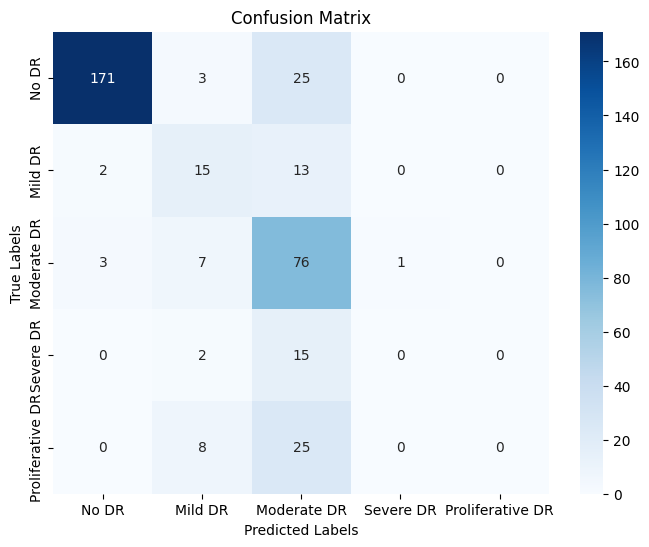

In [ ]:
# Convert true labels to one-hot encoded format
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=5)

# Get the true labels and predicted probabilities for the validation data
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
report = classification_report(np.argmax(y_test_oh, axis=1), predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test_oh, axis=1), predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

ResNet의 Transfer learning은 73% 정도의 정확도를 보이나, Confusion Matrix 결과에서 보이듯이 여전히 4, 5단계의 DR 이미지에 대해서 분류를 잘 하지 못하는 문제가 존재함.

In [ ]:
import tensorflow.keras as keras

# Assuming you have already trained your model and have a trained model object named 'model'

# Save the model using save_model
keras.models.save_model(model, 'efficientnetb4.h5')


<ipython-input-31-5aba05e6a736>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.argmax(y_train_onehot, axis=1), palette="viridis")


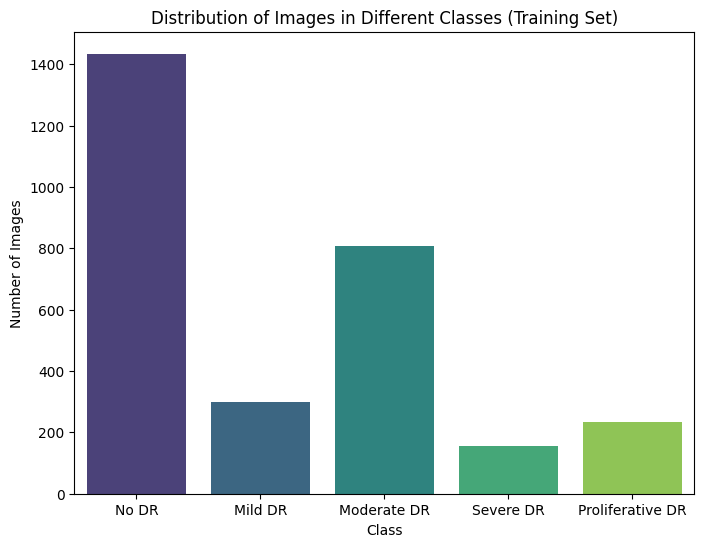

In [ ]:
# train data

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Convert true labels to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=5)

# Plot the distribution of images in different classes for the training set
plt.figure(figsize=(8, 6))
sns.countplot(x=np.argmax(y_train_onehot, axis=1), palette="viridis")
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Different Classes (Training Set)')
plt.xticks(ticks=range(5), labels=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'])
plt.show()

<ipython-input-32-807023d780ec>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.argmax(y_val_onehot, axis=1), palette="viridis")


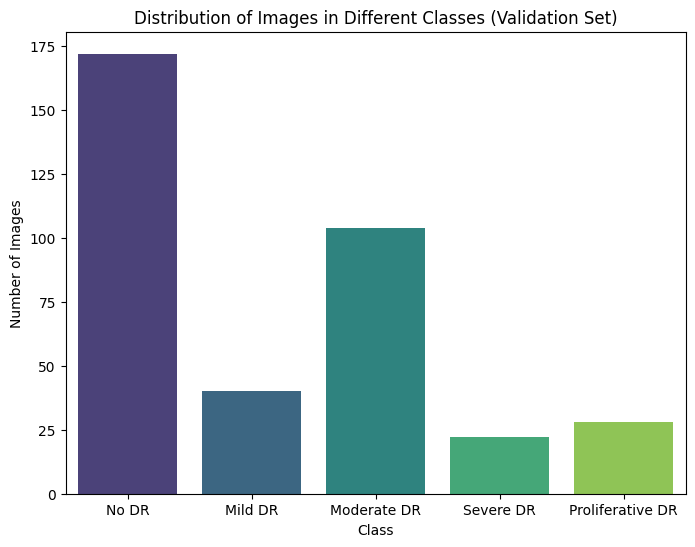

In [ ]:
#val data

y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=5)

plt.figure(figsize=(8, 6))
sns.countplot(x=np.argmax(y_val_onehot, axis=1), palette="viridis")
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Different Classes (Validation Set)')
plt.xticks(ticks=range(5), labels=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'])
plt.show()

<ipython-input-33-aa8701bb4807>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.argmax(y_test_onehot, axis=1), palette="viridis")


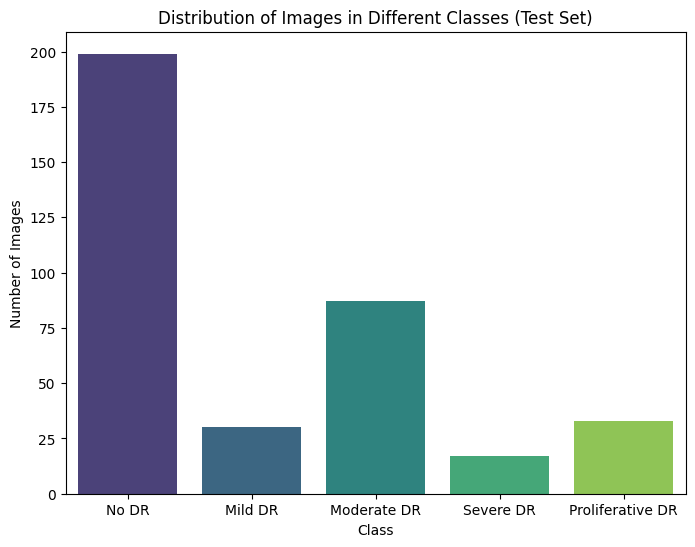

In [ ]:
#test data

y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=5)

plt.figure(figsize=(8, 6))
sns.countplot(x=np.argmax(y_test_onehot, axis=1), palette="viridis")
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Different Classes (Test Set)')
plt.xticks(ticks=range(5), labels=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'])
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the training data
train_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
train_df = pd.read_csv(train_file_path)
train_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images'

# Preprocess training data
train_data = []
train_labels = []
image_size = (224, 224)

for index, row in train_df.iterrows():
    image_path = os.path.join(train_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    train_data.append(image)
    train_labels.append(row['diagnosis'])

# Normalize and one-hot encode training data
X_train = np.array(train_data)
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
y_train = np.array(train_labels, dtype=np.int32)
X_train = np.reshape(X_train, (-1, 224, 224, 3))
y_train = to_categorical(y_train)

# Load the EfficientNetB0 model with pre-trained ImageNet weights, excluding the top (classification) layers
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all base model layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Define additional layers for classification
new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dropout(0.2)(new_model)
new_model = Dense(512, activation='relu')(new_model)
new_model = Dropout(0.2)(new_model)
output = Dense(5, activation='softmax')(new_model)

# Create the final model by combining the base model and the new layers
model_efficientnetB0 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_efficientnetB0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with fine-tuning
history_b0 = model_efficientnetB0.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Unfreeze some layers of the base model for fine-tuning
for layer in model_efficientnetB0.layers[-20:]:
    layer.trainable = True

# Lower the learning rate for fine-tuning
model_efficientnetB0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

# Continue training the model with fine-tuning
history_fine_tuning = model_efficientnetB0.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 194ms/step - accuracy: 0.3387 - loss: 14.9378 - val_accuracy: 0.4915 - val_loss: 1.3046
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4771 - loss: 1.3468 - val_accuracy: 0.4915 - val_loss: 1.2982
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4844 - loss: 1.3415 - val_accuracy: 0.4915 - val_loss: 1.3008
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4949 - loss: 1.3118 - val_accuracy: 0.4915 - val_loss: 1.3067
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4899 - loss: 1.3551 - val_accuracy: 0.4915 - val_loss: 1.3061
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4706 - loss: 1.3390 - val_accuracy: 0.4915 - val_loss: 1.3335
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4934 - loss: 1.3474 - val_accuracy: 0.4915 - val_loss: 1.2988
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s

In [ ]:
# Test Data
test_df = pd.read_csv('/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test.csv')

test_data = []
test_labels = []

image_size = (224,224)

for index, row in test_df.iterrows():
    image_path = f"/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    test_data.append(image)
    test_labels.append(row['diagnosis'])

X_test = np.array(test_data)
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test)).astype(np.float32)
X_test = np.reshape(X_test, (-1, 224, 224, 3))
y_test = np.array(test_labels, dtype=np.int32)
y_test = to_categorical(y_test)

# Model Evaluation
loss, accuracy = model_efficientnetB0.evaluate(X_test,y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 666ms/step - accuracy: 0.5387 - loss: 1.2499
Test loss: 1.2723
Test accuracy: 0.5437


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


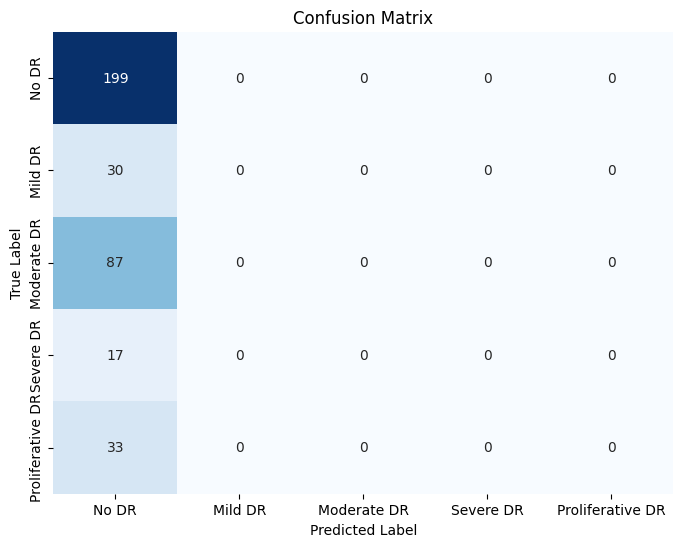

In [ ]:
# Predict the labels for the test data
y_pred = model_efficientnetB0.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측 결과에서 가장 높은 확률을 가진 클래스 선택
y_true = np.argmax(y_test, axis=1)  # 실제 라벨 (one-hot encoded 라벨에서 원래 클래스 라벨로 변환)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

EfficientNetB0는 ResNet보다도 더 class 1번에 편향된 결과를 보이고 적절한 성능을 보이지 못함
결론적으로 부적절하다

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load the training data
train_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
train_df = pd.read_csv(train_file_path)
train_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images'

# Preprocess training data
train_data = []
train_labels = []
image_size = (380, 380)

for index, row in train_df.iterrows():
    image_path = os.path.join(train_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    train_data.append(image)
    train_labels.append(row['diagnosis'])

# Normalize and one-hot encode training data
X_train = np.array(train_data)
X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y_train = np.array(train_labels, dtype=np.int32)
y_train = to_categorical(y_train)

# Load the validation data
val_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/valid.csv'
val_df = pd.read_csv(val_file_path)
val_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/val_images/val_images'

# Preprocess validation data
val_data = []
val_labels = []
for index, row in val_df.iterrows():
    image_path = os.path.join(val_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    val_data.append(image)
    val_labels.append(row['diagnosis'])

# Normalize and one-hot encode validation data
X_val = np.array(val_data)
X_val = X_val.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y_val = np.array(val_labels, dtype=np.int32)
y_val = to_categorical(y_val)

# Load the ResNet152V2 model with pre-trained ImageNet weights
base_model = ResNet152V2(input_shape=(380, 380, 3), include_top=False, weights='imagenet')

# Freeze all base model layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Define additional layers for classification
new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(512, activation='relu')(new_model)
new_model = Dropout(0.5)(new_model)
output = Dense(5, activation='softmax')(new_model)

# Create the final model by combining the base model and the new layers
model_ResNet152V2 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_ResNet152V2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_ResNet152V2 = model_ResNet152V2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 79s 277ms/step - accuracy: 0.6127 - loss: 16.0768 - val_accuracy: 0.6885 - val_loss: 0.7727
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.7281 - loss: 0.9556 - val_accuracy: 0.7322 - val_loss: 0.9181
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.7371 - loss: 0.8679 - val_accuracy: 0.7705 - val_loss: 0.7470
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.7634 - loss: 0.8423 - val_accuracy: 0.7732 - val_loss: 0.6310
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.7844 - loss: 0.6948 - val_accuracy: 0.7623 - val_loss: 0.6082
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.7716 - loss: 0.6580 - val_accuracy: 0.7760 - val_loss: 0.8092
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.7813 - loss: 0.7421 - val_accuracy: 0.7568 - val_loss: 0.6630
Epoch 8/50
184/184 ━━━━━━━━━

In [ ]:
# Test Data
test_df = pd.read_csv('/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test.csv')

test_data = []
test_labels = []

image_size = (380, 380)  # Adjusted to match the input size for ResNeXt50

for index, row in test_df.iterrows():
    image_path = f"/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    test_data.append(image)
    test_labels.append(row['diagnosis'])

X_test = np.array(test_data)
X_test = X_test.astype('float32') / 255.0  # Normalize pixel values to [0, 1] for ResNeXt50
X_test = np.reshape(X_test, (-1, 380, 380, 3))
y_test = np.array(test_labels, dtype=np.int32)
y_test = to_categorical(y_test)

# Model Evaluation
loss, accuracy = model_ResNet152V2.evaluate(X_test, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.8062 - loss: 1.4360
Test loss: 1.2429
Test accuracy: 0.7978


In [ ]:
import tensorflow.keras as keras

# Assuming you have already trained your model and have a trained model object named 'model'

# Save the model using save_model
keras.models.save_model(model_ResNet152V2, 'ResNet152V2.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 942ms/step


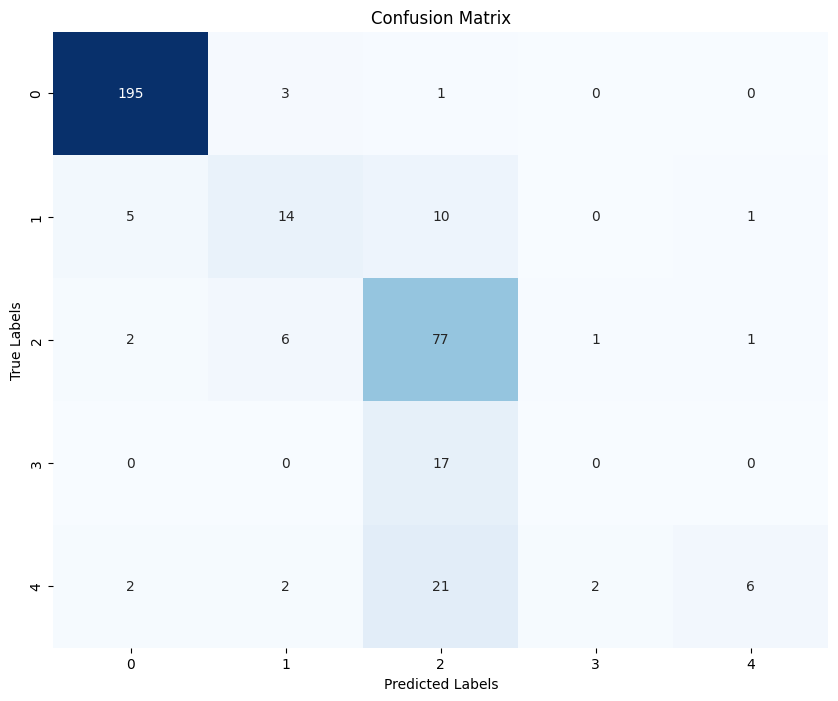

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = model_ResNet152V2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(5) + 0.5, labels=[0, 1, 2, 3, 4])
plt.yticks(ticks=np.arange(5) + 0.5, labels=[0, 1, 2, 3, 4])
plt.show()

In [ ]:
# 가장 성능이 좋은 ResNet152V2를 이용하여 추가적인 학습 진행
# loss function
## 변경 전 cross-entrophy, 변경 후 focal loss
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load the training data
train_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
train_df = pd.read_csv(train_file_path)
train_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images'

# Preprocess training data
train_data = []
train_labels = []
image_size = (380, 380)

for index, row in train_df.iterrows():
    image_path = os.path.join(train_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    train_data.append(image)
    train_labels.append(row['diagnosis'])

# Normalize and one-hot encode training data
X_train = np.array(train_data)
X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y_train = np.array(train_labels, dtype=np.int32)
y_train = to_categorical(y_train)

# Load the validation data
val_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/valid.csv'
val_df = pd.read_csv(val_file_path)
val_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/val_images/val_images'

# Preprocess validation data
val_data = []
val_labels = []
for index, row in val_df.iterrows():
    image_path = os.path.join(val_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    val_data.append(image)
    val_labels.append(row['diagnosis'])

# Normalize and one-hot encode validation data
X_val = np.array(val_data)
X_val = X_val.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y_val = np.array(val_labels, dtype=np.int32)
y_val = to_categorical(y_val)

# Load the ResNet152V2 model with pre-trained ImageNet weights
base_model = ResNet152V2(input_shape=(380, 380, 3), include_top=False, weights='imagenet')

In [ ]:
## Focal loss 함수 정의
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for binary classification.
    :param gamma: Focusing parameter (default: 2.0)
    :param alpha: Balancing parameter (default: 0.25)
    :return: Focal loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate cross-entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate weight that modulates the loss for each sample
        weight = alpha * K.pow((1 - y_pred), gamma)

        # Calculate focal loss
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return focal_loss_fixed

In [ ]:
# Freeze all base model layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Define additional layers for classification
new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(512, activation='relu')(new_model)
new_model = Dropout(0.5)(new_model)
output = Dense(5, activation='softmax')(new_model)

# Create the final model by combining the base model and the new layers
model_ResNet152V2 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_ResNet152V2.compile(loss=focal_loss(gamma=2., alpha=0.25), optimizer='adam', metrics=['accuracy'])

# Train the model
history_ResNet152V2 = model_ResNet152V2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 71s 249ms/step - accuracy: 0.4963 - loss: 1.9486 - val_accuracy: 0.4699 - val_loss: 2.1359
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.4945 - loss: 2.0368 - val_accuracy: 0.4699 - val_loss: 2.1359
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.4917 - loss: 2.0483 - val_accuracy: 0.4699 - val_loss: 2.1359
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.4972 - loss: 2.0260 - val_accuracy: 0.4699 - val_loss: 2.1359
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.4824 - loss: 2.0855 - val_accuracy: 0.4699 - val_loss: 2.1359
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.4999 - loss: 2.0152 - val_accuracy: 0.4699 - val_loss: 2.1359
Epoch 7/50
 43/184 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.5048 - loss: 1.9955

KeyboardInterrupt: 

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 916ms/step


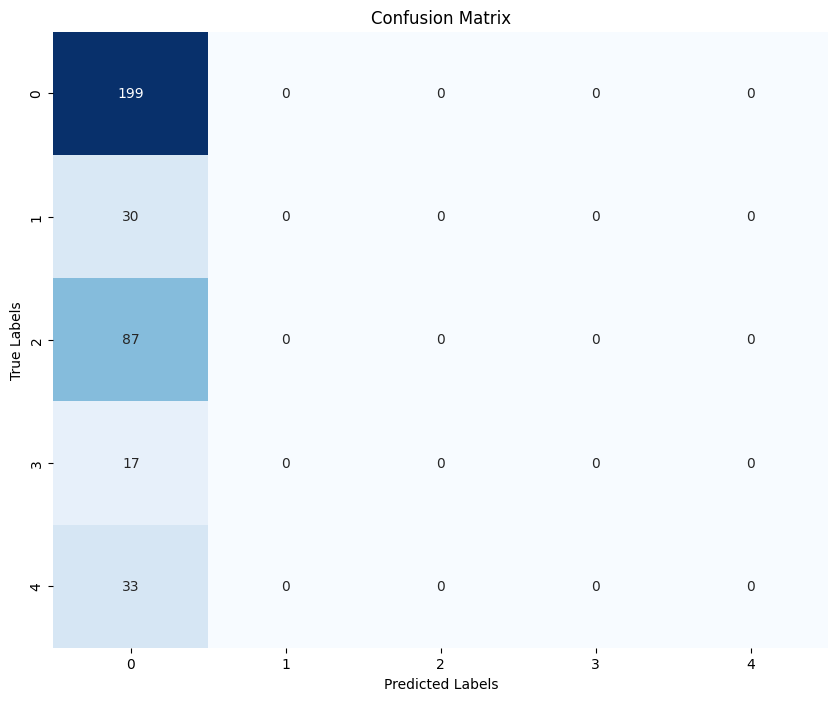

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = model_ResNet152V2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(5) + 0.5, labels=[0, 1, 2, 3, 4])
plt.yticks(ticks=np.arange(5) + 0.5, labels=[0, 1, 2, 3, 4])
plt.show()

Loss에 대한 정의를 바꿨으나, 오답에 편향되는 결과를 나타냄. Representation Learning 기법을 활용해 특징벡터공간을 현재 문제에 적합하게 학습하는 식으로 새롭게 접근

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Lambda, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152V2
import tensorflow.keras.backend as K
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Load the training data
train_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
train_df = pd.read_csv(train_file_path)
train_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images'



# Preprocess training data
train_data = []
train_labels = []
image_size = (380, 380)

# 380 * 380 크기의 3채널(RGB) 이미지를 N장 저장할 수 있는 배열 할당
image_shape = (len(train_df), image_size[0], image_size[1], 3)  # 3000장, 380 * 380 크기, 3 채널 (RGB)
train_data = np.empty(image_shape, dtype=np.float32)  # signed float32로 할당

i = 0
for index, row in train_df.iterrows():
    image_path = os.path.join(train_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)

    train_data[i] = image
    train_labels.append(row['diagnosis'])
    i = i + 1
    print(i, "/", len(train_df))

# Normalize and one-hot encode training data
X_train = train_data #np.array(train_data)
X_train = X_train / 255.0  # Normalize pixel values to [0, 1]
y_train = np.array(train_labels, dtype=np.int32)


1 / 2930
2 / 2930
3 / 2930
4 / 2930
5 / 2930
6 / 2930
7 / 2930
8 / 2930
9 / 2930
10 / 2930
11 / 2930
12 / 2930
13 / 2930
14 / 2930
15 / 2930
16 / 2930
17 / 2930
18 / 2930
19 / 2930
20 / 2930
21 / 2930
22 / 2930
23 / 2930
24 / 2930
25 / 2930
26 / 2930
27 / 2930
28 / 2930
29 / 2930
30 / 2930
31 / 2930
32 / 2930
33 / 2930
34 / 2930
35 / 2930
36 / 2930
37 / 2930
38 / 2930
39 / 2930
40 / 2930
41 / 2930
42 / 2930
43 / 2930
44 / 2930
45 / 2930
46 / 2930
47 / 2930
48 / 2930
49 / 2930
50 / 2930
51 / 2930
52 / 2930
53 / 2930
54 / 2930
55 / 2930
56 / 2930
57 / 2930
58 / 2930
59 / 2930
60 / 2930
61 / 2930
62 / 2930
63 / 2930
64 / 2930
65 / 2930
66 / 2930
67 / 2930
68 / 2930
69 / 2930
70 / 2930
71 / 2930
72 / 2930
73 / 2930
74 / 2930
75 / 2930
76 / 2930
77 / 2930
78 / 2930
79 / 2930
80 / 2930
81 / 2930
82 / 2930
83 / 2930
84 / 2930
85 / 2930
86 / 2930
87 / 2930
88 / 2930
89 / 2930
90 / 2930
91 / 2930
92 / 2930
93 / 2930
94 / 2930
95 / 2930
96 / 2930
97 / 2930
98 / 2930
99 / 2930
100 / 2930
101 / 29

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)

정확하진 않으나, 지속적으로 메모리를 확충하는 동작이 있는 듯함 코드를 수정해서 한 번에 큰 메모리를 잡을 수 있도록 설정해야 할 것으로 보임

메모리를 크게 할당하는 건 학습 이미지 로드 시간 절약에 큰 의미가 없음. 오히려 할당 받았던 자원 크기 내 재할당은 빠르게 동작하나, 초기 메모리 영역 확충하는 것은 속도가 더딤. 원인 모름

In [ ]:
import numpy as np
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import backend as K
import tensorflow as tf

# 1. Triplet Loss 정의
def triplet_loss(margin=1.0):
  def _triplet_loss(y_true, y_pred):
      anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
      # 양성(Positive)과 앵커(Anchor) 사이의 거리
      pos_dist = K.sum(K.square(anchor - positive), axis=-1)
      # 음성(Negative)과 앵커(Anchor) 사이의 거리
      neg_dist = K.sum(K.square(anchor - negative), axis=-1)
      # 손실 값 계산 (margin을 이용해 양성과 음성 간의 거리를 조정)
      loss = K.maximum(pos_dist - neg_dist + margin, 0)
      return K.mean(loss)
  return _triplet_loss

# Cosine similarity 기반의 Triplet Loss 함수 정의
def cosine_triplet_loss(margin=0.1):
    def loss(y_true, y_pred):
        # y_pred는 anchor, positive, negative 벡터가 하나로 합쳐져 입력됨
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

        # 벡터 정규화 (L2 norm으로 정규화)
        anchor = tf.nn.l2_normalize(anchor, axis=1)
        positive = tf.nn.l2_normalize(positive, axis=1)
        negative = tf.nn.l2_normalize(negative, axis=1)

        # Anchor-Positive, Anchor-Negative 사이의 Cosine similarity 계산
        pos_similarity = K.sum(anchor * positive, axis=1)
        neg_similarity = K.sum(anchor * negative, axis=1)

        # Triplet Loss 계산: max(0, neg_similarity - pos_similarity + margin)
        loss_value = K.maximum(0.0, neg_similarity - pos_similarity + margin)

        # 평균 손실 반환
        return K.mean(loss_value)

    return loss

# 2. ResNet152V2 모델 생성
input_shape = (380, 380, 3)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Global Average Pooling을 사용해 2D 출력을 1D 벡터로 변환
output = base_model.output
output = GlobalAveragePooling2D()(output)

# 모델 구성 (특징 벡터를 추출하는 모델)
embedding_model = Model(inputs=base_model.input, outputs=output)

def generate_triplet_data(train_data, train_labels, num_iterations=3000):
    triplets = []
    anchor = []
    positive = []
    negative = []

    for _ in range(num_iterations):
        # 0~4번 클래스 중에서 Anchor 선택
        anchor_label = np.random.choice([0, 1, 2, 3, 4])
        anchor_indices = np.where(train_labels == anchor_label)[0]

        # Positive는 동일한 클래스에서 Anchor와 다른 인덱스를 선택
        pos_idx = np.random.choice(anchor_indices)
        while True:
            anchor_idx = np.random.choice(anchor_indices)
            if anchor_idx != pos_idx:
                break

        # Positive와 Anchor 데이터 선택
        anchor.append(train_data[anchor_idx])
        positive.append(train_data[pos_idx])

        # Negative는 다른 클래스에서 선택 (Anchor 클래스 제외한 0~4번 중에서 선택)
        negative_label = np.random.choice([i for i in [0, 1, 2, 3, 4] if i != anchor_label])
        negative_indices = np.where(train_labels == negative_label)[0]
        neg_idx = np.random.choice(negative_indices)

        # Negative 데이터 선택
        negative.append(train_data[neg_idx])

        # 생성된 triplet을 리스트에 추가
        #triplets.append((anchor, positive, negative))

    return anchor, positive, negative

# 예시 데이터 (X_train: 이미지 데이터, train_labels: 이미지 라벨)
# X_train과 train_labels는 미리 정의된 데이터셋이라고 가정
anchor, positive, negative = generate_triplet_data(X_train, np.array(train_labels))

# # 선택된 앵커, 양성, 음성 데이터를 확인 (이미지 배열 출력)
# print(f"Anchor shape: {anchor.shape}")
# print(f"Positive shape: {positive.shape}")
# print(f"Negative shape: {negative.shape}")

# 4. Triplet 모델 구성
def create_triplet_model(embedding_model):
  # 앵커, 양성, 음성 입력 생성
  input_shape = (380, 380, 3)
  input_anchor = Input(shape=input_shape, name='anchor_input')
  input_positive = Input(shape=input_shape, name='positive_input')
  input_negative = Input(shape=input_shape, name='negative_input')

  # ResNet152V2 기반의 임베딩 모델을 통해 특징 벡터 추출
  encoded_anchor = embedding_model(input_anchor)
  encoded_positive = embedding_model(input_positive)
  encoded_negative = embedding_model(input_negative)

  # 세 가지 출력을 하나의 텐서로 결합하여 Triplet Loss에 전달
  merged = Lambda(lambda x: K.stack([x[0], x[1], x[2]], axis=1))([encoded_anchor, encoded_positive, encoded_negative])

  # Triplet 학습용 모델 구성
  triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged)

  # Triplet Loss로 모델 컴파일
  triplet_model.compile(optimizer='adam', loss=cosine_triplet_loss(margin=0.2))

  return triplet_model

# 5. Triplet 모델 생성
triplet_model = create_triplet_model(embedding_model)

# 6. 모델 학습
# 데이터를 여러 샘플로 확장해서 학습 진행
num_samples = 3000  # 학습 데이터 샘플 개수
anchors, positives, negatives = generate_triplet_data(X_train, np.array(train_labels), num_iterations=num_samples)

# Triplet 학습 데이터셋 준비
anchors = np.array(anchors)
positives = np.array(positives)
negatives = np.array(negatives)

print(anchors.shape)
print(positives.shape)
print(negatives.shape)

# 더미 라벨 생성 (Triplet Loss에서는 필요 없음)
y_dummy = np.zeros((anchors.shape[0],))

# Triplet 모델 학습
triplet_model.fit([anchors, positives, negatives], y_dummy, epochs=10, batch_size=8)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
(3000, 380, 380, 3)
(3000, 380, 380, 3)
(3000, 380, 380, 3)
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 337s 203ms/step - loss: 0.2028
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1607
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1654
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1644
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1600
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1513
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1515
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1389
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1499
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - loss: 0.1526


In [ ]:
triplet_model.save("/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/triplet_model_weights.h5")

In [ ]:
embedding_model.save("/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/embedding_model_weights.h5")

In [ ]:
triplet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer) │ (None, 380, 380, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive_input            │ (None, 380, 380, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative_input            │ (None, 380, 380, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 2048)           │     58,331,648 │ anchor_input[0][0],    │
│                           │                        │                │ positive_input[0][0],  │
│                           │                        │                │ negative_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 3, 2048)        │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[1][0],    │
│                           │                        │                │ functional_1[2][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 174,707,458 (666.46 MB)

 Trainable params: 58,187,904 (221.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

 Optimizer params: 116,375,810 (443.94 MB)

In [ ]:
from tensorflow.keras import backend as K

# 모델 삭제
del embedding_model

# 세션 정리
K.clear_session()

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the training data
train_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
train_df = pd.read_csv(train_file_path)
train_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images'

# Preprocess training data
train_data = []
train_labels = []
image_size = (380, 380)

# 380 * 380 크기의 3채널(RGB) 이미지를 N장 저장할 수 있는 배열 할당
image_shape = (len(train_df), image_size[0], image_size[1], 3)  # 3000장, 380 * 380 크기, 3 채널 (RGB)
train_data = np.empty(image_shape, dtype=np.float32)  # signed float32로 할당

i = 0
for index, row in train_df.iterrows():
    image_path = os.path.join(train_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)

    train_data[i] = image
    train_labels.append(row['diagnosis'])
    i = i + 1
    print(i, "/", len(train_df))

# Normalize and one-hot encode training data
X_train = train_data #np.array(train_data)
X_train = X_train / 255.0  # Normalize pixel values to [0, 1]
y_train = np.array(train_labels, dtype=np.int32)

1 / 2930
2 / 2930
3 / 2930
4 / 2930
5 / 2930
6 / 2930
7 / 2930
8 / 2930
9 / 2930
10 / 2930
11 / 2930
12 / 2930
13 / 2930
14 / 2930
15 / 2930
16 / 2930
17 / 2930
18 / 2930
19 / 2930
20 / 2930
21 / 2930
22 / 2930
23 / 2930
24 / 2930
25 / 2930
26 / 2930
27 / 2930
28 / 2930
29 / 2930
30 / 2930
31 / 2930
32 / 2930
33 / 2930
34 / 2930
35 / 2930
36 / 2930
37 / 2930
38 / 2930
39 / 2930
40 / 2930
41 / 2930
42 / 2930
43 / 2930
44 / 2930
45 / 2930
46 / 2930
47 / 2930
48 / 2930
49 / 2930
50 / 2930
51 / 2930
52 / 2930
53 / 2930
54 / 2930
55 / 2930
56 / 2930
57 / 2930
58 / 2930
59 / 2930
60 / 2930
61 / 2930
62 / 2930
63 / 2930
64 / 2930
65 / 2930
66 / 2930
67 / 2930
68 / 2930
69 / 2930
70 / 2930
71 / 2930
72 / 2930
73 / 2930
74 / 2930
75 / 2930
76 / 2930
77 / 2930
78 / 2930
79 / 2930
80 / 2930
81 / 2930
82 / 2930
83 / 2930
84 / 2930
85 / 2930
86 / 2930
87 / 2930
88 / 2930
89 / 2930
90 / 2930
91 / 2930
92 / 2930
93 / 2930
94 / 2930
95 / 2930
96 / 2930
97 / 2930
98 / 2930
99 / 2930
100 / 2930
101 / 29

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)

In [ ]:
# Load the validation data
val_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/valid.csv'
val_df = pd.read_csv(val_file_path)
val_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/val_images/val_images'

# Preprocess validation data
val_data = []
val_labels = []
for index, row in val_df.iterrows():
    image_path = os.path.join(val_folder_path, f"{row['id_code']}.png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    val_data.append(image)
    val_labels.append(row['diagnosis'])

# Normalize and one-hot encode validation data
X_val = np.array(val_data)
X_val = X_val.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y_val = np.array(val_labels, dtype=np.int32)

In [ ]:
# Load the validation data
val_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/valid.csv'
val_df = pd.read_csv(val_file_path)
val_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/val_images/val_images'

# Preprocess validation data
val_labels = []
for index, row in val_df.iterrows():
    val_labels.append(row['diagnosis'])
# print(y_train)
# print(y_val)#

from tensorflow.keras.utils import to_categorical
y_val = to_categorical(y_val)

# Load the training data
train_file_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_1.csv'
train_df = pd.read_csv(train_file_path)
train_folder_path = '/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/train_images/train_images'

# Preprocess training data
image_size = (380, 380)
train_labels = []
for index, row in train_df.iterrows():
    train_labels.append(row['diagnosis'])
y_train = np.array(train_labels, dtype=np.int32)
y_train = to_categorical(y_train)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=-1)  # Sum over classes
    return focal_loss_fixed


# 0. 저장된 Attention trained data load, Transfer learning
embedding_model = load_model("/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/embedding_model_weights.h5")

# Freeze all base model layers to prevent them from being updated during training
n = 6  # 상위 n개의 레이어를 학습 가능하게 설정
for layer in embedding_model.layers[:-n]:
    layer.trainable = False

# 상위 두 레이어를 학습 가능하게 설정
for layer in embedding_model.layers[-n:]:
    layer.trainable = True

# 1. embedding_model의 CNN 출력 뒤에 Dense Layer 추가
cnn_output = embedding_model.output  # embedding_model의 출력 (CNN 마지막 층)

#embedding_model.summary()
# 2. Flatten과 Dense Layer 추가
new_model = Flatten()(cnn_output[0])
new_model = Dropout(0.5)(new_model)  # Dropout for regularization
new_model = Dense(512, activation='relu')(new_model)  # Fully connected layer
new_model = Dropout(0.5)(new_model)  # Dropout for regularization
output = Dense(5, activation='softmax')(new_model)  # Output layer with softmax (5 classes)

# 3. 새로운 모델 정의 (embedding_model의 CNN + Dense Layer)
model_with_dense = Model(inputs=embedding_model.input, outputs=output)

# 4. 모델 컴파일
model_with_dense.compile(loss=focal_loss(4, 0.5), optimizer='adam', metrics=['accuracy'])
#model_with_dense.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# 5. 데이터셋 준비 (X_train, y_train, X_val, y_val은 미리 준비된 데이터셋이라고 가정)
# 학습 시작
#history = model_with_dense.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)
history = model_with_dense.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-46-9e98bb6f6dd6>", line 48, in <cell line: 48>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 1478830632 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_896570]

In [ ]:
# Test Data
test_df = pd.read_csv('/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test.csv')

test_data = []
test_labels = []

image_size = (380, 380)  # Adjusted to match the input size for ResNeXt50

for index, row in test_df.iterrows():
    image_path = f"/content/drive/MyDrive/semicolon/yuji/DR/aptos2019-blindness-detection-V2/test_images/test_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    test_data.append(image)
    test_labels.append(row['diagnosis'])

X_test = np.array(test_data)
X_test = X_test.astype('float32') / 255.0  # Normalize pixel values to [0, 1] for ResNeXt50
X_test = np.reshape(X_test, (-1, 380, 380, 3))
y_test = np.array(test_labels, dtype=np.int32)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


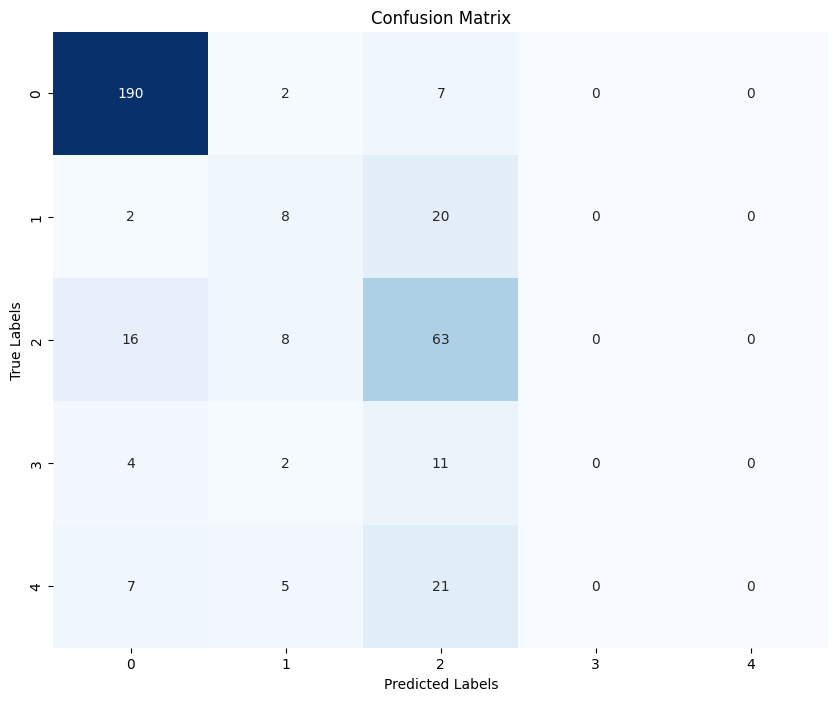

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = model_with_dense.predict(X_test)

# If y_pred is a probability distribution, convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

# If y_test is not one-hot encoded, use it directly as true labels
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(5) + 0.5, labels=[0, 1, 2, 3, 4])
plt.yticks(ticks=np.arange(5) + 0.5, labels=[0, 1, 2, 3, 4])
plt.show()